In [1]:
!pip install sentencepiece
!pip install tf_sentencepiece

     |████████████████████████████████| 1.0MB 2.9MB/s 
     |████████████████████████████████| 2.8MB 2.9MB/s 


In [2]:
!pip install fastai==1.0.52

     |████████████████████████████████| 225kB 2.8MB/s 
  Found existing installation: fastai 1.0.54
    Uninstalling fastai-1.0.54:
      Successfully uninstalled fastai-1.0.54


In [0]:
from fastai import *
from fastai.text import *

import re
import sentencepiece as spm

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import os
path = Path(os.getcwd())
path = path/'gdrive'/'My Drive'
news=path/'Thesis Data'/'full doc csv'
aa=path/'Thesis Data'/'Our dataset'
aa2=path/'Thesis Data'/'AA dataset'
subsets=aa/'subsets'

# Load SP

In [0]:
vocab_size = 30000
model_prefix = 'sp'

In [7]:
#Head of the Vocab file: Line nums indicate index of vocab
!head -n10 {model_prefix}.vocab | nl

     1	<unk>	0
     2	<s>	0
     3	</s>	0
     4	▁	-1.92809
     5	।	-3.08075
     6	,	-3.75831
     7	"	-3.82833
     8	▁"	-4.22803
     9	▁ও	-4.91756
    10	র	-4.94756


In [8]:
## load up the Processor
sp = spm.SentencePieceProcessor()
sp.load(f'{model_prefix}.model')

True

In [0]:
itos = [] #{}
with open(f'{model_prefix}.vocab','r') as f:
    for line_num,line in enumerate(f):
        itos.append(line.split("\t")[0])

In [10]:
len(itos)

30000

In [11]:
itos[:5], itos[-5:]

(['<unk>', '<s>', '</s>', '▁', '।'],
 ['ইমরুল', '▁কামরাঙ্গীর', '▁whe', '▁অভ্যন্তরী', '/'])

In [0]:
class SPTokenizer(BaseTokenizer):
    "Wrapper around a SentncePiece tokenizer to make it a `BaseTokenizer`."
    def __init__(self, model_prefix:str):
        self.tok = spm.SentencePieceProcessor()
        self.tok.load(f'{model_prefix}.model')

    def tokenizer(self, t:str) -> List[str]:
        return self.tok.EncodeAsPieces(t)
    
class CustomTokenizer():
    '''Wrapper for SentencePiece toeknizer to fit into Fast.ai V1'''
    def __init__(self,tok_func:Callable,model_prefix:str, pre_rules:ListRules=None):
        self.tok_func,self.model_prefix = tok_func,model_prefix
        self.pre_rules  = ifnone(pre_rules,  defaults.text_pre_rules )
        
    def __repr__(self) -> str:
        res = f'Tokenizer {self.tok_func.__name__} using `{self.model_prefix}` model with the following rules:\n'
        for rule in self.pre_rules: res += f' - {rule.__name__}\n'
        return res        

    def process_text(self, t:str,tok:BaseTokenizer) -> List[str]:
        "Processe one text `t` with tokenizer `tok`."
        for rule in self.pre_rules: t = rule(t)  
        toks = tok.tokenizer(t)
        #post rules?
        return toks 
    
    def _process_all_1(self,texts:Collection[str]) -> List[List[str]]:
        'Process a list of `texts` in one process'
        tok = self.tok_func(self.model_prefix)
        return [self.process_text(t,tok) for t in texts]
                                                                     
    def process_all(self, texts:Collection[str]) -> List[List[str]]: 
        "Process a list of `texts`."                                 
        return self._process_all_1(texts)

In [0]:
#setup Vocab object for use in LM
sp_vocab = Vocab(itos)

In [0]:
mycust_tok = CustomTokenizer(SPTokenizer,model_prefix)

# BAAD16 subdatasets

## 6 Authors

#### 6 authors LM

In [0]:
data_lm_AA = TextLMDataBunch.from_csv(subsets , '6train.csv', bs=bs , bptt=bptt,tokenizer=mycust_tok, vocab=sp_vocab)
data_lm_AA.save('6train_AA_subword_lm.pkl')

In [0]:
data_lm_AA = load_data(subsets, '6train_AA_subword_lm.pkl',bs=bs)

In [0]:
data_lm_AA.show_batch()

idx,text
0,"তি কাল ▁পরে ▁দারোগা র ▁পায়ে ▁ধর িয়া ছি ▁ , ▁তা ঁ হার ▁মহ দা শ য় তার ▁উল্লেখ ▁করিয়া ▁অনেক ▁ স্তু তি ▁এবং ▁নিজের ▁বুদ্ধি ভ ্র ংশ ▁ ল ইয়া ▁অনেক ▁আত্ম ধিক ্ ▁কার ▁প্রয়োগ ▁করিয়া ছি ▁ , ▁কিন্তু ▁শেষ টা ▁ ভিটা ▁ছাড় িতে ▁হই ল ▁ । ▁শুনি য়া ছি , ▁আজকাল ▁অনেক ▁বাঙালির ▁মেয়েকে ▁নিজের ▁চেষ্টায় ▁স্বামী ▁সংগ্রহ ▁করি তে ▁হয়"
1,"▁জন ্তু র ▁মতো ▁গ োঁ ▁গ োঁ ▁শব্দ ▁হচ্ছে । ▁সে ▁চেষ্টা ▁করেও ▁শব্দ ▁আটকাতে ▁পারছে ▁না । ▁নাদিয়া ▁চমকে ▁তা কাল । ▁ভাদু কে ▁দেখে ▁অবাক ▁হয়ে ▁বলল , ▁এই ▁তোমার ▁কী ▁হয়েছে ? ▁এরকম ▁কর ছ ▁কেন ? ▁ভাদু ▁নাদিয়া র ▁ওপর ▁ঝাঁপিয়ে ▁পড়ল । ▁ দিঘি র ▁পানিতে ▁নাদিয়া ▁পড়ে ▁আছে । ▁তার ▁চোখ ▁খোলা । ▁যেন ▁সে ▁অবাক ▁হয়ে ▁পৃথিবী ▁দেখছে । ▁নাদিয়া ▁ দিঘি"
2,", ▁তুই ▁জানি স ▁না , ▁আমি ▁কান্না ▁সহ্য ▁করতে ▁পারি ▁না ! ▁থামা ▁ওদের ! ▁যা , ▁ বস্তির ▁সব ▁ক টা ▁লোককে ▁একটা ▁করে ▁টাকা ▁দিয়ে ▁আয় । ▁মুন্সী ▁আমীর ▁আলী ▁আজ ▁একটা ▁বিরাট ▁সুসংবাদ ▁শুনিয়েছেন । ▁শেখ ▁ইমদাদ , ▁কত ুল ু ▁আর ▁হে দায় ে ৎ কে ▁ডাক , ▁তো রাও ▁এসে ▁শো ন । ▁তার ▁আগে ▁ বস্তির ▁সবাইকে ▁টাকা ▁দিয়ে ▁বল বি ▁মে ঠা"
3,"▁দেখল ো , ▁একটি ▁গ বা ক্ষ ের ▁কাছে ▁দাঁড়িয়ে ▁বাইরে ▁অন্ধকার ের ▁দিকে ▁চেয়ে ▁স রোজ িনী ▁গুনগুন িয়ে ▁গাইছে , ▁আমি ▁যে ▁লা জে ▁ মরি , ▁মনের ▁ কতা ▁কই তে ▁পারি ▁ নে , ▁কত ▁লোকে ▁কত ▁ কতা ▁বলে , ▁আমি ▁যে ▁সইতে ▁পারি । ▁ নে । ▁নবীন কুমার ের ▁সর্ব াঙ্গ ▁ অক স্ মা ৎ ▁শি হর িত ▁হলো । ▁সাদা ▁রেশম"
4,"▁ডাক ▁দেয় , ▁বলে ▁চলো , ▁বিশ্বাস ▁আছে ▁কিছু ! ▁গুটি ▁সাজাতে ▁সাজাতে ▁বল রেন ▁ সরি ৎ শেখ র । ▁আর ▁হঠাৎ ▁সমস্ত ▁শরীরে ▁কাঁটা ▁দিয়ে ▁উঠেছিল ▁অনি র । ▁ঝা ড়ি কাকু ▁বলেছিল , ▁মানুষ ▁মরে ▁গেলে ▁ভূত ▁হয় । ▁এখন ▁ সরি ৎ শেখ র ▁একা ▁এক মনে ▁দাবা ▁খেলছেন । ▁সম্প্রতি ▁ দাত ▁বা ধ িয়েছেন ▁তিনি । ▁বাঁ দিক ের ▁টেবিলে ▁একটা ▁পে য়াল ার"


In [0]:
learn = language_model_learner(data_lm_AA, AWD_LSTM, pretrained=False, drop_mult=0.5)

In [0]:
learn.load(news/'models'/'news_subword_lm_31');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


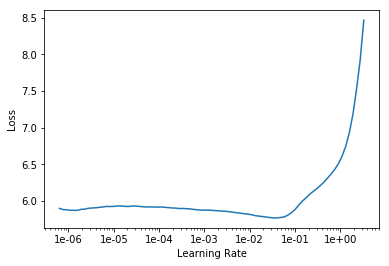

In [0]:
learn.lr_find();
learn.recorder.plot();

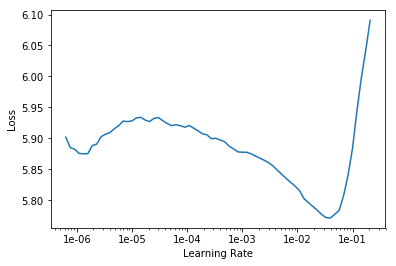

In [0]:
learn.recorder.plot(skip_end=20);

In [0]:
learn.freeze()
learn.fit_one_cycle(2, 1e-3)
learn.save('6train_subword_lm_head');

epoch,train_loss,valid_loss,accuracy,time
0,5.087208,4.907931,0.220560,06:59
1,5.012203,4.830989,0.227429,07:07


In [0]:
learn.freeze_to(-2)
learn.fit_one_cycle(2, 1e-3)
learn.save('6train_subword_lm_body_1');

epoch,train_loss,valid_loss,accuracy,time
0,4.746109,4.621097,0.248333,07:19
1,4.616107,4.547030,0.255648,07:18


In [0]:
learn.freeze_to(-3)
learn.fit_one_cycle(2, 1e-3)
learn.save('6train_subword_lm_body_2');

epoch,train_loss,valid_loss,accuracy,time
0,4.538266,4.444046,0.267226,07:51
1,4.358920,4.372641,0.275446,07:51


In [0]:
learn.unfreeze()
learn.fit_one_cycle(2, 1e-3)
learn.save('6train_subword_lm_body_3');

epoch,train_loss,valid_loss,accuracy,time
0,4.349091,4.345245,0.278285,08:10
1,4.157496,4.289122,0.285175,08:09


In [0]:
learn.fit_one_cycle(2, 1e-3)
learn.save('6train_subword_lm_body_4')
learn.save_encoder('6train_subword_lm_enc')

epoch,train_loss,valid_loss,accuracy,time
0,4.206298,4.284727,0.285345,08:13
1,4.144996,4.239679,0.291049,08:13


In [0]:
learn.fit_one_cycle(2, 1e-3)
learn.save('6train_subword_lm_body_5')
# learn.save_encoder('6train_subword_lm_enc')

epoch,train_loss,valid_loss,accuracy,time
0,4.200545,4.244983,0.289546,08:10
1,4.005004,4.208224,0.294353,08:09


In [0]:
learn.fit_one_cycle(4, 1e-3)
learn.save('6train_subword_lm_body_6')
# learn.save_encoder('6train_subword_lm_enc') #total 16epochs (10 unfrozen)

epoch,train_loss,valid_loss,accuracy,time
0,4.053096,4.227893,0.292057,08:09
1,4.051779,4.205906,0.294669,08:10
2,3.950754,4.174600,0.298680,08:09
3,3.823169,4.172399,0.299650,08:10


In [0]:
learn.fit_one_cycle(1, 1e-3)
learn.save('6train_subword_lm_body_7')
learn.save_encoder('6train_subword_lm_enc') #total 17epochs (11 unfrozen)

epoch,train_loss,valid_loss,accuracy,time
0,3.908700,4.171709,0.299598,08:10


#### 6 Authors Clas

In [0]:
data_clas = TextClasDataBunch.from_csv(subsets , '6train.csv', tokenizer=mycust_tok, vocab=sp_vocab, bs=bs)
data_clas.save('6train_subword_clas.pkl')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


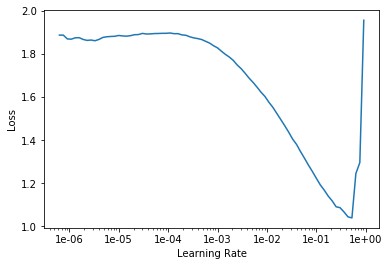

In [0]:
data_clas = load_data(subsets, '6train_subword_clas.pkl',bs=bs)
learn_cls = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5, pretrained=False)
learn_cls.load_encoder('6train_subword_lm_enc')
learn_cls.freeze()
learn_cls.lr_find()
learn_cls.recorder.plot()

In [0]:
learn_cls.fit_one_cycle(2, 1e-2, moms=(0.8,0.7))
learn_cls.save('6train_subword_cls_1')
# learn_cls.load('6train_subword_cls_1')
learn_cls.freeze_to(-2)
learn_cls.fit_one_cycle(2 , slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))
learn_cls.save('6train_subword_cls_2')
# learn_cls.load('6train_subword_cls_2')
learn_cls.freeze_to(-3)
learn_cls.fit_one_cycle(2, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))
learn_cls.save('6train_subword_cls_3')
# learn_cls.load('6train_subword_cls_3')
learn_cls.unfreeze()
learn_cls.fit_one_cycle(4, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))
learn_cls.save('6train_subword_cls_4')

epoch,train_loss,valid_loss,accuracy,time
0,0.271309,0.012543,0.997162,02:48
1,0.125881,0.009407,0.997162,02:49


epoch,train_loss,valid_loss,accuracy,time
0,0.203336,0.030321,0.989593,03:06
1,0.074691,0.009576,0.996216,03:11


epoch,train_loss,valid_loss,accuracy,time
0,0.060481,0.035118,0.994324,04:31
1,0.029494,0.022599,0.993378,04:28


epoch,train_loss,valid_loss,accuracy,time
0,0.025032,0.022774,0.993378,05:29
1,0.024567,0.022565,0.993378,05:39
2,0.026857,0.020215,0.992431,05:40
3,0.028328,0.016997,0.994324,05:37


In [0]:
learn_cls.data.test_dl == None

True

------------->  **Testing**  <-----------------

In [0]:
data_clas = load_data(subsets, '6train_subword_clas.pkl',bs=bs)
learn_cls = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5, pretrained=False)
learn_cls.load('6train_subword_cls_4');

In [0]:
pred,targ = testing(subsets/'6test.csv')

1320
Accuracy: 
0.9946969696969697
[('robindronath', 'shunil_gongopaddhay'), ('robindronath', 'shomresh'), ('robindronath', 'shorotchandra'), ('humayun_ahmed', 'shorotchandra'), ('humayun_ahmed', 'shunil_gongopaddhay'), ('humayun_ahmed', 'MZI'), ('shomresh', 'robindronath')]


In [0]:
from sklearn.metrics import f1_score
# y_true = [0, 1, 2, 0, 1, 2]
# y_pred = [0, 2, 1, 0, 0, 1]
# output : array([ 0.8,  0. ,  0. ])
# Which is the scores for each class.
out  = f1_score(targ, pred, average=None) #'macro' , also == weighted cuz dataset is balanced
out

array([0.997732, 0.993135, 0.990868, 0.995455, 0.995475, 0.995475])

In [0]:
out.mean()

0.9946899648921779

## 8 Authors

#### 8 authors LM

In [0]:
bs=32

In [0]:
data_lm_AA = TextLMDataBunch.from_csv(subsets , '8train.csv', bs=bs,tokenizer=mycust_tok, vocab=sp_vocab)
data_lm_AA.save('8train_AA_subword_lm.pkl')

In [0]:
data_lm_AA = load_data(subsets, '8train_AA_subword_lm.pkl',bs=bs)

In [0]:
data_lm_AA.show_batch()

idx,text
0,"▁মত ▁আমরা ▁ ই ণ্ড িয়ান দের ▁ছোট ▁মনে ▁করি নে , ▁নিজেদের ▁সম কক্ষ ই ▁ভাবি , — কেবল ▁ফার্ম ের ▁নয় , ▁আপনাদের ▁নিজেদের ▁উন্নতি ও ▁আপনাদের ▁নিজেদের ▁কর্তব্য জ্ঞান ের ▁উপরে — আচ্ছা , ▁গুড ▁ডে — আ ফিস ▁দুটো র ▁সময় ▁বন্ধ ▁হওয়া ▁চাই — ইত্যাদি ▁বলি তে ▁বলি তে ▁তিনি ▁যেমন ▁ ক্ষ ি প্র পদে ▁প্রবেশ ▁করিয়া ছিলেন , ▁তেমনি ▁ ক্ষ ি প্র"
1,"। ▁চাঁদাবাজ া দের ▁অত্যাচার ▁দিন ▁দিন ▁বাড়ছে । ▁তারপর ▁ধর ▁সিদ্দিক ▁বাজারের ▁মানিক ▁লাল ▁ থু পী র ▁নিজস্ব ▁সম্পত্তির ▁অর্ধেক ▁অংশ ▁এলাকার ▁সাহাবুদ্দিন , ▁সিরাজ , ▁পারভেজ , ▁সালাউদ্দিন ▁এরা ▁জোর ▁করে ▁দখল ▁করে ▁নিয়েছে । ▁এখন ▁তারা ▁মানিক ▁লাল ের ▁পুরো ▁সম্পত্তি ▁নিয়ে ▁নেব ার ▁চেষ্টা ▁চালাচ্ছে । ▁সু রঞ্জন ▁কিছুক্ষণ ▁থেমে ▁দীর্ঘশ্বাস ▁ছেড়ে ▁বলে — ধান ▁কেটে ▁নেওয়া , ▁মেয়ে ▁ধরে ▁নিয়ে ▁যাওয়া , ▁ র"
2,"▁ঢেউয়ে র ▁উপর ▁দিয়ে ▁জাহাজ ▁যখন ▁ টল ্ ▁মল ্ ▁করতে ▁করতে ▁চলেছে , ▁একটি ▁ছোট ো ▁ ডাঙা র ▁পাখি ▁উড়ে ▁এসে ▁যেন ▁মা স্তু লে ▁বসল ; ▁ক্ষুব্ধ ▁সমুদ্র ের ▁ভিতর ▁ ক্ষণ কালের ▁জন্যে ▁মনে ▁এনে ▁দিলে ▁শ্যামল ▁ দ্বীপের ▁ নিভৃত ▁বন চ্ছা য়ার ▁ছবি । ▁কিন্তু ▁সে ▁কথায় ▁মন ▁দেবার ▁সময় ▁নয় , ▁জাহাজ ▁চালাতে ▁হবে । ▁মধুসূদন ▁আপন ▁মনের ▁এই টুকু ▁চাঞ্চল্য ে"
3,য়া দা ▁যখন ▁দরজা ▁ছাড়ে ▁না ▁তখন ▁দায়ে ▁পড়ে ▁ভাবতে ▁হল ▁কী ▁লিখি । ▁সময়ের ▁দাবি ▁বদলে ▁গেছে । ▁এ কালে ▁গল্পের ▁কৌতূহল টা ▁হয়ে ▁উঠেছে ▁মনো বিক লন মূলক । ▁ঘটনা - গ্রন্থ ন ▁হয়ে ▁পড়েছে ▁গৌণ । ▁তাই ▁অস্বাভাবিক ▁অবস্থায় ▁মনের ▁রহস্য ▁সন্ধান ▁করে ▁নায়ক - নায়িকা র ▁জীবনে ▁প্র কাণ্ড ▁একটা ▁ভুলের ▁দম ▁লাগিয়ে ▁দেওয়া ▁হয়েছিল ▁ – অত্যন্ত ▁নিষ্ঠুর ▁কিন্তু ▁ <unk> ৎস ুক ্য জনক
4,"▁ রত্ন েশ্বরী ▁জবাব ▁দেয়ার ▁আগেই ▁তার ▁বাবা ▁বললেন , ▁আপনি ▁এখন ▁যান । ▁আমরা ▁হাঁস - ফা স ▁কিছু ▁রাখব ▁না । ▁ ই র তাজ উদ্দিন ▁ক্লান্ত ▁গলায় ▁বললেন , ▁ আচ্ছা ▁না ▁রাখলেন , ▁গো ট টা ▁খ ুল ুন । ▁আমার ▁বাথরুমে ▁যাওয়া ▁বিশেষ ▁প্রয়োজন । ▁ রত্ন েশ্বরী র ▁বাবা ▁বললেন , ▁গেট ▁খোলা ▁যাবে ▁না । ▁আমার ▁কাছে ▁গেটের ▁চাবি ▁নাই । ▁কথা ▁সত্যি"


In [0]:
learn = language_model_learner(data_lm_AA, AWD_LSTM, pretrained=False, drop_mult=0.5)

In [0]:
learn.load(news/'models'/'news_subword_lm_31');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


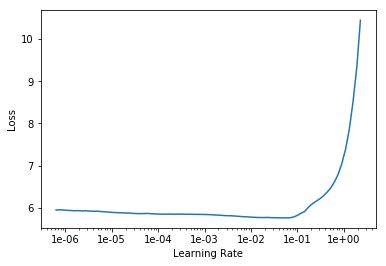

In [0]:
learn.lr_find();
learn.recorder.plot();

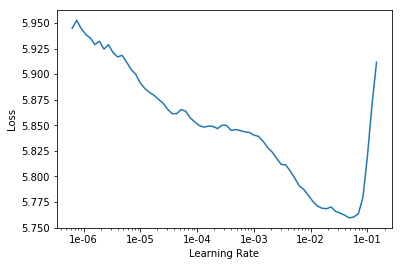

In [0]:
learn.recorder.plot(skip_end=20);

In [0]:
learn.freeze()
learn.fit_one_cycle(2, 1e-3)
learn.save('8train_subword_lm_head');

epoch,train_loss,valid_loss,accuracy,time
0,5.200167,5.010797,0.211414,07:49
1,5.062052,4.943041,0.217093,08:00


In [0]:
learn.freeze_to(-2)
learn.fit_one_cycle(2, 1e-3)
learn.save('8train_subword_lm_body_1');

epoch,train_loss,valid_loss,accuracy,time
0,4.873001,4.756652,0.234854,08:15
1,4.782453,4.684672,0.242304,08:11


In [0]:
learn.freeze_to(-3)
learn.fit_one_cycle(2, 1e-3)
learn.save('8train_subword_lm_body_2');

epoch,train_loss,valid_loss,accuracy,time
0,4.706996,4.587357,0.252385,08:48
1,4.516606,4.514170,0.261331,08:50


In [0]:
learn.unfreeze()
learn.load('8train_subword_lm_body_2');
learn.fit_one_cycle(4, 1e-3)
learn.save('8train_subword_lm_body_3');
learn.save_encoder('8train_subword_lm_enc')

epoch,train_loss,valid_loss,accuracy,time
0,4.420300,4.506402,0.261631,09:00
1,4.466517,4.441250,0.268502,09:10
2,4.385371,4.388586,0.275027,09:10
3,4.231692,4.376570,0.276654,09:11


In [0]:
learn.fit_one_cycle(2, 1e-3)
learn.save('8train_subword_lm_body_4')

epoch,train_loss,valid_loss,accuracy,time
0,4.306743,4.388829,0.274594,09:11
1,4.140616,4.353124,0.279541,09:12


In [0]:
learn.fit_one_cycle(2, 1e-3)
learn.save('8train_subword_lm_body_5')

epoch,train_loss,valid_loss,accuracy,time
0,4.178640,4.366120,0.277537,09:12
1,4.105770,4.334311,0.281622,09:11


In [0]:
learn.fit_one_cycle(2, 1e-3)
learn.save('8train_subword_lm_body_6')

epoch,train_loss,valid_loss,accuracy,time
0,4.190300,4.352106,0.279121,09:11
1,4.033255,4.322569,0.283336,09:12


In [0]:
learn.save_encoder('8train_subword_lm_enc')

#### 8 Authors Clas

In [0]:
data_clas = TextClasDataBunch.from_csv(subsets , '8train.csv', tokenizer=mycust_tok, vocab=sp_vocab, bs=bs)
data_clas.save('8train_subword_clas.pkl')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


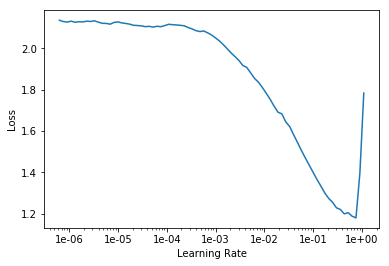

In [0]:
data_clas = load_data(subsets, '8train_subword_clas.pkl',bs=bs)
learn_cls = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5, pretrained=False)
learn_cls.load_encoder('8train_subword_lm_enc')
learn_cls.freeze()
learn_cls.lr_find()
learn_cls.recorder.plot()

In [0]:
learn_cls.fit_one_cycle(2, 1e-2, moms=(0.8,0.7))
learn_cls.save('8train_subword_cls_1')
# learn_cls.load('8train_subword_cls_1')
learn_cls.freeze_to(-2)
learn_cls.fit_one_cycle(2 , slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))
learn_cls.save('8train_subword_cls_2')
# learn_cls.load('8train_subword_cls_2')
learn_cls.freeze_to(-3)
learn_cls.fit_one_cycle(2, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))
learn_cls.save('8train_subword_cls_3')
# learn_cls.load('8train_subword_cls_3')
learn_cls.unfreeze()
learn_cls.fit_one_cycle(4, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))
learn_cls.save('8train_subword_cls_4')

epoch,train_loss,valid_loss,accuracy,time
0,0.207758,0.017768,0.994962,03:08
1,0.066687,0.014304,0.995802,03:07


epoch,train_loss,valid_loss,accuracy,time
0,0.141669,0.019680,0.992443,03:30
1,0.058855,0.018762,0.995802,03:28


epoch,train_loss,valid_loss,accuracy,time
0,0.056105,0.027293,0.994123,05:03
1,0.022821,0.017731,0.996641,05:01


epoch,train_loss,valid_loss,accuracy,time
0,0.015067,0.011548,0.998321,06:18
1,0.017571,0.013096,0.998321,06:07
2,0.016812,0.011537,0.998321,06:21
3,0.008808,0.012647,0.997481,06:19


------------->  **Testing**  <-----------------

In [0]:
def testing(dts):
  df = pd.read_csv(dts) 
  text_array = df["text"].tolist()
  print(len(text_array))

  final_preds = []

  for text in text_array:
      preds = learn_cls.predict(text)
      final_preds.append(str(preds[0]))

  targets = df["label"].tolist()

  err=[]
  count =0;
  tst = len(text_array)

  for i in range(tst):
      if(targets[i]==final_preds[i]):
          count = count+1
      else:
  #         print(targets[i] + ", " + final_preds[i] + ';')
          err.append((targets[i],final_preds[i]))
  print("Accuracy: ")
  print(count/tst)
  print(err)
  
  return final_preds,targets

In [0]:
pred,targ = testing(subsets/'8test.csv')

1496
Accuracy: 
0.9939839572192514
[('shirshendu', 'shorotchandra'), ('shirshendu', 'shorotchandra'), ('toslima_nasrin', 'shirshendu'), ('shorotchandra', 'robindronath'), ('humayun_ahmed', 'shorotchandra'), ('humayun_ahmed', 'MZI'), ('humayun_ahmed', 'MZI'), ('shomresh', 'MZI'), ('shunil_gongopaddhay', 'MZI')]


In [0]:
from sklearn.metrics import f1_score
out  = f1_score(targ, pred, average=None) #'macro' , also == weighted cuz dataset is balanced
out

array([0.989418, 0.991914, 0.997333, 0.991957, 0.997319, 0.989362, 0.997319, 0.997319])

In [0]:
out.mean()

0.9939926225781239

## 10 Authors

#### 10 authors LM

In [0]:
bs=32

In [0]:
data_lm_AA = TextLMDataBunch.from_csv(subsets , '10train.csv', bs=bs,tokenizer=mycust_tok, vocab=sp_vocab)
data_lm_AA.save('10train_AA_subword_lm.pkl')

In [0]:
data_lm_AA = load_data(subsets, '10train_AA_subword_lm.pkl',bs=bs)

In [0]:
data_lm_AA.show_batch()

idx,text
0,▁জড়িয়ে ▁ধরে ▁চুমু ▁খাওয়া কেই ▁নারী ▁স্বাধীনতা ▁বলেই ▁ভাবেন ▁হয়ত — ও ঁ দের ▁গা ▁থেকে ▁ভু র ▁ভু র ▁করে ▁টাকার ▁গন্ধ ▁বেরিয়ে ▁ঘর কে ▁এত ▁ ঠে সে ▁ধরে ছিল ▁যে ▁আমার ▁শ্বাস ▁নিতে ▁কষ্ট ▁হচ্ছিল । ▁এই ▁নির্ বোধ ▁মেয়েরা ▁কঠিন ▁পানীয় ের ▁গ্লাস ▁হাতে ▁নিয়ে ▁শরীর ▁দু লিয়ে ▁ বিত্ত ▁এবং ▁বৈ ভ বের ▁গল্প ▁বলেন । ▁লোকে ▁ও ঁ দের ▁শিক্ষিত ▁এবং ▁স ন্ত্র ান্ত
1,"▁মানুষকে ▁সাথে ▁নিয়ে ▁হেঁটে ▁আসছিলেন , ▁তখন ▁রাস্তায় ▁দুইটা ▁মিলি টার ী ▁তাকে ▁থামিয়ে ছে । ▁খান ▁সাহেবের ▁সাথে ▁কি ▁সব ▁কথাবার্তা ▁বলেছে । ▁তারপর ▁যেই ▁সামনে ▁হেঁটে ▁যেতে ▁চেষ্টা ▁করেছেন ▁মিলি টার ী ▁দুইটা ▁বন্দুক ▁তুলে ▁গুল ী ▁করতে ▁শুরু ▁করেছে । ▁সাথে র ▁দুইজন ▁উল্টো ▁দিকে ▁দৌড় ▁দেয়ার ▁চেষ্টা ▁করেছে , ▁তখন ▁তাদেরকে ও ▁গুল ী ▁করে ▁মেরে ▁ফেলেছে । ▁সাথে ▁সাথে ▁মরে ▁গেছে ▁সবাই ? ▁সেটা ▁জানি"
2,। ▁— ▁কী ▁খায় ▁না ▁খায় ▁তা ▁ জাই না ▁আমার ▁কী ! ▁না ▁খ াইয়া ▁ম ই রা ▁যাক । ▁ভু গু ক । ▁আমার ▁কী ! ▁তুমি ▁হই লা ▁নষ্ট ের ▁গোড়া । ▁তুমি ▁কথা ▁কই ও ▁না । ▁তু মার ▁আস কারা ▁পাই য়া ▁ছেলেমেয়ে গুলা ▁নষ্ট ▁হইছে । ▁মা ▁ শির দা ঁড়া ▁টান ▁টান ▁করে ▁হেঁটে ▁এসে ▁চি বুক ▁উঁচিয়ে ▁বলেন ▁— ▁কথা ▁কই তাম
3,"▁তখন ▁ট্রেনের ▁শব্দ ▁ছাড়া ▁আর ▁একটা ▁শব্দ ▁কানে ▁এল । ▁ঘোড়ার ▁খু র ের ▁শব্দ । ▁এর ▁মধ্যে ▁কখন ▁যে ▁বাঁ দিকে ▁পাহাড় ▁এসে ▁গেছে , ▁তা ▁খেয়াল ই ▁করিনি । ▁ফেল ু দার ▁পকেটে ▁যখন ▁হাত ▁ঢোকা চ্ছি । ▁তখন ▁দেখলাম ▁পাহাড়ের ▁গা ▁দিয়ে ▁ধুলো ▁উড়িয়ে ▁ডাকাত ের ▁দল ▁নামছে । ▁রিভ ল ভার ের ▁পাশে ▁হাত ড়া তেই ▁চাবি ▁ঠেকা ল ▁হাতে । ▁দিয়ে ▁দে । ▁আমি ▁চাবি"
4,"ই ▁বালিশ ের ▁তলা ▁হইতে ▁একটা ▁টাকা ▁ ঠ ং ▁করিয়া ▁ফেল িয়া ▁দিল । ▁ সাবিত্রী ▁টাকা টা ▁তুলি য়া ▁ ল ইয়া ▁বলি ল , ▁সকালবেলা য় ▁আবার ▁কি ▁আনতে ▁হবে ? ▁সতীশ ▁বলি ল , ▁সন্ দেশ ! ▁কিন্তু ▁আমার ▁জন্যে ▁নয় । ▁এখন ▁রেখে ▁দাও , ▁রাত ্রে ▁তোমার ▁বাবুর ▁জন্যে ▁কিনে ▁নিয়ে ▁যে ও । ▁ সাবিত্রী ▁রাগ ▁করিয়া ▁টাকা টা ▁বিছানা র ▁উপর ▁ফেল"


In [0]:
learn = language_model_learner(data_lm_AA, AWD_LSTM, pretrained=False, drop_mult=0.5)

In [0]:
learn.load(news/'models'/'news_subword_lm_31');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


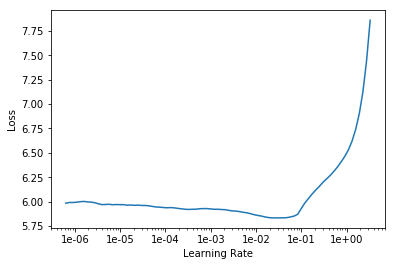

In [0]:
learn.lr_find();
learn.recorder.plot();

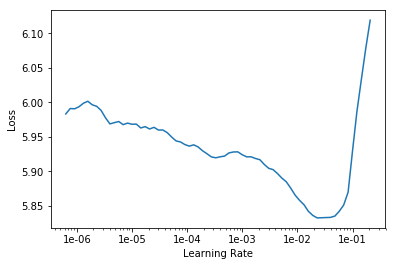

In [0]:
learn.recorder.plot(skip_end=20);

In [0]:
learn.freeze()
learn.fit_one_cycle(2, 1e-2)
learn.save('10train_subword_lm_head');

epoch,train_loss,valid_loss,accuracy,time
0,5.143362,5.000328,0.213516,09:17
1,4.865668,4.802146,0.230835,09:20


In [0]:
learn.freeze_to(-2)
learn.fit_one_cycle(2, 1e-2)
learn.save('10train_subword_lm_body_1');

epoch,train_loss,valid_loss,accuracy,time
0,4.802526,4.822278,0.233453,09:37
1,4.614734,4.580323,0.257463,09:36


In [0]:
learn.freeze_to(-3)
learn.fit_one_cycle(2, 1e-2)
learn.save('10train_subword_lm_body_2');

epoch,train_loss,valid_loss,accuracy,time
0,4.779698,4.737345,0.242182,10:14
1,4.477612,4.467874,0.270867,10:14


In [0]:
learn.unfreeze()
learn.load('10train_subword_lm_body_2');
learn.fit_one_cycle(4, 1e-2)
learn.save('10train_subword_lm_body_3');
learn.save_encoder('10train_subword_lm_enc')

epoch,train_loss,valid_loss,accuracy,time
0,4.713316,4.692276,0.246457,10:41
1,4.623757,4.644120,0.251632,10:39
2,4.431570,4.436760,0.273235,10:39
3,4.151529,4.367658,0.281893,10:41


In [0]:
learn.fit_one_cycle(2, 1e-3)
learn.save('10train_subword_lm_body_4')

epoch,train_loss,valid_loss,accuracy,time
0,4.092285,4.358439,0.282594,10:41
1,4.042577,4.346851,0.284444,10:42


In [0]:
learn.fit_one_cycle(2, 1e-3)
learn.save('10train_subword_lm_body_5')

epoch,train_loss,valid_loss,accuracy,time
0,4.093029,4.345499,0.284234,10:40
1,4.018605,4.335114,0.285803,10:42


In [0]:
learn.fit_one_cycle(2, 1e-3)
learn.save('10train_subword_lm_body_6')

epoch,train_loss,valid_loss,accuracy,time
0,4.014836,4.336262,0.285745,10:41
1,4.012425,4.327955,0.286807,10:41


In [0]:
learn.save_encoder('10train_subword_lm_enc')

#### 10 Authors Clas

In [0]:
data_clas = TextClasDataBunch.from_csv(subsets , '10train.csv', tokenizer=mycust_tok, vocab=sp_vocab, bs=bs)
data_clas.save('10train_subword_clas.pkl')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


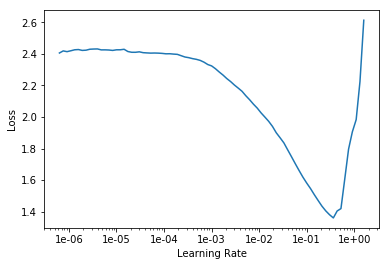

In [0]:
data_clas = load_data(subsets, '10train_subword_clas.pkl',bs=bs)
learn_cls = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5, pretrained=False)
learn_cls.load_encoder('10train_subword_lm_enc')
learn_cls.freeze()
learn_cls.lr_find()
learn_cls.recorder.plot()

In [0]:
learn_cls.fit_one_cycle(2, 1e-2, moms=(0.8,0.7))
learn_cls.save('10train_subword_cls_1')
# learn_cls.load('10train_subword_cls_1')
learn_cls.freeze_to(-2)
learn_cls.fit_one_cycle(2 , slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))
learn_cls.save('10train_subword_cls_2')
# learn_cls.load('10train_subword_cls_2')
learn_cls.freeze_to(-3)
learn_cls.fit_one_cycle(2, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))
learn_cls.save('10train_subword_cls_3')
# learn_cls.load('10train_subword_cls_3')
learn_cls.unfreeze()
learn_cls.fit_one_cycle(4, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))
learn_cls.save('10train_subword_cls_4')

epoch,train_loss,valid_loss,accuracy,time
0,0.211635,0.019091,0.996321,03:43
1,0.110166,0.014108,0.996321,03:38


epoch,train_loss,valid_loss,accuracy,time
0,0.105510,0.018480,0.996321,04:03
1,0.038198,0.013876,0.994113,04:05


epoch,train_loss,valid_loss,accuracy,time
0,0.032894,0.018970,0.994849,05:56
1,0.028797,0.008189,0.997057,05:45


epoch,train_loss,valid_loss,accuracy,time
0,0.013769,0.005042,0.998528,07:22
1,0.016858,0.003186,0.998528,07:20
2,0.015124,0.003872,0.999264,07:14
3,0.011513,0.003026,0.999264,07:13


------------->  **Testing**  <-----------------

In [0]:
pred,targ = testing(subsets/'10test.csv')

1700
Accuracy: 
0.9870588235294118
[('shordindu', 'shunil_gongopaddhay'), ('shordindu', 'shunil_gongopaddhay'), ('shordindu', 'shorotchandra'), ('shordindu', 'robindronath'), ('shottojit_roy', 'humayun_ahmed'), ('shottojit_roy', 'shordindu'), ('shirshendu', 'robindronath'), ('shirshendu', 'shorotchandra'), ('shirshendu', 'robindronath'), ('shirshendu', 'robindronath'), ('MZI', 'humayun_ahmed'), ('MZI', 'humayun_ahmed'), ('robindronath', 'shunil_gongopaddhay'), ('robindronath', 'shorotchandra'), ('robindronath', 'shorotchandra'), ('robindronath', 'shordindu'), ('robindronath', 'shorotchandra'), ('humayun_ahmed', 'MZI'), ('humayun_ahmed', 'toslima_nasrin'), ('humayun_ahmed', 'shomresh'), ('shomresh', 'shunil_gongopaddhay'), ('shunil_gongopaddhay', 'shordindu')]


In [0]:
from sklearn.metrics import f1_score
out  = f1_score(targ, pred, average=None) #'macro' , also == weighted cuz dataset is balanced
out

array([0.99115 , 0.982353, 0.973451, 0.988095, 0.994118, 0.979351, 0.985507, 0.994083, 0.985423, 0.997067])

In [0]:
out.mean()

0.9870598904509045

## 12 Authors

#### 12 authors LM

In [0]:
bs=32

In [0]:
data_lm_AA = TextLMDataBunch.from_csv(subsets , '12train.csv', bs=bs,tokenizer=mycust_tok, vocab=sp_vocab)
data_lm_AA.save('12train_AA_subword_lm.pkl')

In [0]:
data_lm_AA = load_data(subsets, '12train_AA_subword_lm.pkl',bs=bs)

In [0]:
data_lm_AA.show_batch()

idx,text
0,"▁চোখ ▁নামিয়ে ▁ফেলি , ▁যেন ▁পড়ি নি ▁কোনও ▁প্রশ্ন । ▁চোখের ▁তীক্ষ ্ম তা ▁দেখিনি । ▁মেডিকেল ের ▁ছাত্রছাত্রীরা ▁চেনা ▁রোগ ি ▁নিয়ে ▁এমন ▁কি ▁রাস্তায় ▁পড়ে ▁থেকে ▁কাত রাতে ▁থাকা ▁রোগীদের ▁দয়া ▁করে ▁তো ▁চিকিৎসার ▁ব্যবস্থা ▁করে । ▁এরকম ই ▁হয়ত ▁কিছু । ▁হাসপাতালের ▁করিডোর ে ▁এক ▁লোক ▁হাঁটছি ল , ▁আমার ▁সাহায্য ▁চাই ল ▁তার ▁রোগের ▁চিকিৎসার ▁জন্য । ▁আমার ▁অবসর ▁ছিল ▁বলে , ▁ঠিক ▁এ ক্ষ ু"
1,"▁পাবেন ▁না । ▁আপনি ▁কি ▁বলছেন ? ▁দীপ াবলী র ▁গলা ▁চড়া য় ▁উঠল । ▁সেটা ▁কানে ▁যাওয়া ▁মাত্র ▁ নে তিয়ে ▁পড়ল ▁প বন । ▁তার ▁মুখ ▁দেখে ▁বোঝার ▁উপায় ▁নেই ▁সে ▁একটু ▁আগে ▁কথাগুলো ▁বলেছে । ▁সুপারভাইজার ▁হেসে ▁ফেললেন , ▁কিছু ▁মনে ▁করবেন ▁না ▁ম্যাডাম ▁ও ▁ইচ্ছে ▁করে ▁বলছে ▁না । ▁এতদিন ▁যা ▁শুনেছে ▁তাই ▁উ গর ে ▁দিল । ▁শুনেছে ▁মানে ? ▁ও ▁আমার ▁কাছে ▁টাকা ▁চাইছে"
2,▁না । ▁তাহলে ▁ভালো ▁একটা ▁জিনিস ▁মিস ▁করল ি । ▁আমার ▁কাছে ▁পাঁচটা ▁ছবি ▁আছে । ▁একেকটা ▁ছবি ▁দেখতে ▁দশ ▁টাকা ▁করে ▁লাগবে । ▁কী ▁ছবি ? ▁কী ▁ছবি ▁বুঝতে ▁পারছি স ▁না ? ▁ওই সব ▁ছবি — হু ঁ ▁হু ঁ । ▁ওই সব ▁ছবি ▁দেখার ▁আমার ▁কোনো ▁শখ ▁নেই । ▁না ▁দেখেই ▁বলে ▁ফেলল ি ? ▁ছবিগুলো ▁সব ▁টিভি ▁স্টার দের । ▁এদের ▁কাণ্ড কারখানা ▁দেখলে ▁মাথায় ▁হাত
3,"নম ্র ▁হইয়া ▁নিজেকে ▁যত ই ▁আড়ালে ▁রাখি বার ▁চেষ্টা ▁করি তে ছেন ▁ততই ▁এই ▁পরিবারের ▁পক্ষে ▁উপদ্রব স্বরূপ ▁হইয়া ▁উঠি তে ছেন । ▁এজন্য ▁তাহার ▁মাস ির ▁অত্যন্ত ▁লজ্জা ▁xx b os ▁পেরেছে ? ▁অন ঙ্গ ▁বলি ল — সম্ভব ▁নয় । ▁নূতন ▁লোক ▁দেখলেই ▁বোধহয় ▁পিছনে ▁গুপ্তচর ▁লাগে । ▁কিছুক্ষণ ▁চিন্তা ▁করিয়া ▁বলি ল — গুপ্ত চর টা ▁আমার ▁পিছু ▁নিয়েছে , ▁তোর ▁নয় । ▁কারণ ▁লক্ষ্মী কর্ণ"
4,"▁না ▁পেরে ▁একটু ▁পরে ▁পরে ▁লম্বা ▁দীর্ঘশ্বাস ▁ফেলতে ▁ফেলতে ▁কাজ ▁করে ▁যেতে ▁লাগল াম । ▁ রেজ িষ্ট ্র েশন ▁কাজ ▁শেষ ▁হবার ▁পর ▁আমি ▁বিজ্ঞানী ▁অনিক ▁লু ম্বা কে ▁খুঁজে ▁বের ▁করার ▁চেষ্টা ▁করলাম । ▁হল ঘরে ▁ছোট ▁ছোট ▁অনেক ▁টেবিল ▁বসানো ▁হয়েছে , ▁সেই ▁টেবিল গুলোর ▁ওপর ▁পদ চারী ▁বিজ্ঞানীদের ▁নানারকম ▁গবেষণা ▁সাজানো । ▁গোবর ▁নিয়ে ▁নিশ্চয়ই ▁অনেকগুলো ▁আবিষ্কার ▁রয়েছে ▁কারণ ▁হল ঘরের ▁ভেতরে ▁কেমন ▁জানি ▁গোবর ▁গোবর"


In [0]:
learn = language_model_learner(data_lm_AA, AWD_LSTM, pretrained=False, drop_mult=0.5)

In [0]:
learn.load(news/'models'/'news_subword_lm_31');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


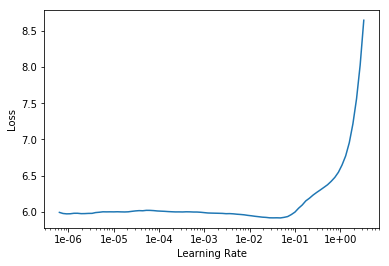

In [0]:
learn.lr_find();
learn.recorder.plot();

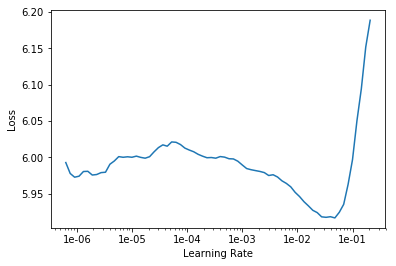

In [0]:
learn.recorder.plot(skip_end=20);

In [0]:
learn.freeze()
learn.fit_one_cycle(2, 1e-2)
learn.save('12train_subword_lm_head');

epoch,train_loss,valid_loss,accuracy,time
0,5.138184,5.035399,0.209476,07:41
1,4.869359,4.840404,0.226911,07:40


In [0]:
learn.freeze_to(-2)
learn.fit_one_cycle(2, 1e-2)
learn.save('12train_subword_lm_body_1');

epoch,train_loss,valid_loss,accuracy,time
0,4.873079,4.856602,0.228935,07:54
1,4.681571,4.624383,0.253004,07:54


In [0]:
learn.freeze_to(-3)
learn.fit_one_cycle(2, 1e-2)
learn.save('12train_subword_lm_body_2');

epoch,train_loss,valid_loss,accuracy,time
0,4.750702,4.777611,0.239023,08:25
1,4.423241,4.515964,0.265806,08:25


In [0]:
learn.unfreeze()
learn.load('12train_subword_lm_body_2');
learn.fit_one_cycle(4, 1e-2)
learn.save('12train_subword_lm_body_3');
learn.save_encoder('12train_subword_lm_enc')

epoch,train_loss,valid_loss,accuracy,time
0,4.600021,4.735528,0.242530,08:48
1,4.683197,4.677899,0.248369,08:47
2,4.397318,4.482227,0.269210,08:45
3,4.115621,4.420777,0.276749,08:46


In [0]:
learn.fit_one_cycle(2, 1e-3)
learn.save('12train_subword_lm_body_4')

epoch,train_loss,valid_loss,accuracy,time
0,4.091744,4.411273,0.277801,08:46
1,4.018851,4.402796,0.279101,08:48


In [0]:
learn.fit_one_cycle(2, 1e-3)
learn.save('12train_subword_lm_body_5')

epoch,train_loss,valid_loss,accuracy,time
0,4.053686,4.398780,0.279440,08:48
1,3.960006,4.392306,0.280355,08:51


In [0]:
learn.fit_one_cycle(2, 1e-3)
learn.save('12train_subword_lm_body_6')

epoch,train_loss,valid_loss,accuracy,time
0,3.982544,4.391653,0.280154,08:50
1,3.935635,4.386615,0.281373,08:49


In [0]:
learn.save_encoder('12train_subword_lm_enc')

#### 12 Authors Clas

In [0]:
data_clas = TextClasDataBunch.from_csv(subsets , '12train.csv', tokenizer=mycust_tok, vocab=sp_vocab, bs=bs)
data_clas.save('12train_subword_clas.pkl')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


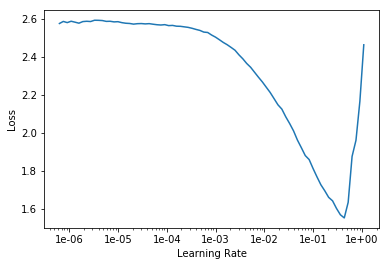

In [0]:
data_clas = load_data(subsets, '12train_subword_clas.pkl',bs=bs)
learn_cls = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5, pretrained=False)
learn_cls.load_encoder('12train_subword_lm_enc')
learn_cls.freeze()
learn_cls.lr_find()
learn_cls.recorder.plot()

In [0]:
learn_cls.fit_one_cycle(2, 1e-2, moms=(0.8,0.7))
learn_cls.save('12train_subword_cls_1')
# learn_cls.load('12train_subword_cls_1')
learn_cls.freeze_to(-2)
learn_cls.fit_one_cycle(2 , slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))
learn_cls.save('12train_subword_cls_2')
# learn_cls.load('12train_subword_cls_2')
learn_cls.freeze_to(-3)
learn_cls.fit_one_cycle(2, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))
learn_cls.save('12train_subword_cls_3')
# learn_cls.load('12train_subword_cls_3')
learn_cls.unfreeze()
learn_cls.fit_one_cycle(4, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))
learn_cls.save('12train_subword_cls_4')

epoch,train_loss,valid_loss,accuracy,time
0,0.333907,0.037936,0.987941,03:03
1,0.106213,0.020397,0.995362,03:00


epoch,train_loss,valid_loss,accuracy,time
0,0.108847,0.028935,0.990724,03:25
1,0.062164,0.022104,0.994434,03:21


epoch,train_loss,valid_loss,accuracy,time
0,0.067252,0.023621,0.992579,04:43
1,0.032698,0.016062,0.992579,04:44


epoch,train_loss,valid_loss,accuracy,time
0,0.016443,0.018635,0.991651,06:00
1,0.017689,0.021239,0.992579,06:02
2,0.013530,0.024645,0.991651,05:52
3,0.008614,0.019893,0.992579,06:02


------------->  **Testing**  <-----------------

In [0]:
pred,targ = testing(subsets/'12test.csv')

1356
Accuracy: 
0.995575221238938
[('shordindu', 'robindronath'), ('shirshendu', 'shomresh'), ('robindronath', 'tarashonkor'), ('robindronath', 'shottojit_roy'), ('humayun_ahmed', 'MZI'), ('shomresh', 'robindronath')]


In [0]:
from sklearn.metrics import f1_score
out  = f1_score(targ, pred, average=None) #'macro' , also == weighted cuz dataset is balanced
out

array([0.995595, 1.      , 0.995556, 0.982301, 0.995556, 0.99115 , 0.995556, 1.      , 0.995595, 1.      , 0.995595,
       1.      ])

In [0]:
out.mean()

0.9955751779224548

-------------xxxx---------------

## 14 Authors

#### 14 authors LM

In [0]:
bs=32

In [0]:
data_lm_AA = TextLMDataBunch.from_csv(subsets , '14train.csv', bs=bs,tokenizer=mycust_tok, vocab=sp_vocab)
data_lm_AA.save('14train_AA_subword_lm.pkl')

In [0]:
data_lm_AA = load_data(subsets, '14train_AA_subword_lm.pkl',bs=bs)

In [0]:
data_lm_AA.show_batch()

idx,text
0,"▁উপরে ▁যে ▁অভিশাপ ▁লেগেছে ! ▁সে ▁কী ▁হে , ▁তুমি ▁আবার ▁অভিশাপ - ট ভি শা পে ▁বিশ্বাস ▁কর ▁কবে ▁থেকে ? — অ খিল বাবু ▁আমাদের ▁দিকে ▁এগিয়ে ▁এলেন । ▁ মহেশ বাবু ▁দীর্ঘশ্বাস ▁ফেলে ▁বললেন , ▁তুমি ▁আমার ▁কো ষ্ঠ ী ই ▁বিচার ▁করেছি । ▁অ খিল , ▁মানুষ টাকে ▁বিচার ▁কর নি । ▁ওই খানে ই ▁তো ▁ভুল , ▁বললেন ▁অ খিল বাবু , ▁মানুষের ▁কু ষ্ঠ"
1,"▁ বেহায়া র ▁দল ▁ওই ▁আট প ৌ র েরা ! ▁অনেক ▁কষ্টে ▁ক াহার েরা ▁নিষ্ কৃত ি ▁পেয়েছে । ▁সু চাঁদ ▁বলে — ▁এক ▁পুরুষ ▁গেল , ▁দু ▁পুরুষ ে ▁সবাই ▁দাগ ী ▁হল । ▁ক াহার েরা ▁তখন ▁চাষ ে বাসে ▁মন ▁দিলে ; ▁চুরি চা মারি ও ▁করত , ▁কিন্তু ক ▁আগের ▁মতন ▁ লয় । ▁তবু ▁দাগ ীর ▁বিপদ ▁যাবে ▁কোথায় ? ▁চুরি ▁হলে ▁ক"
2,"▁না ▁হয় ▁এবং ▁বিনয় ের ▁সঙ্গে ▁তাহার ▁বিচ্ছেদের ▁যেন ▁কোনো ▁কারণ ▁না ▁ঘটে । ▁২২ ▁গোলাপ ▁ফুলের ▁একটু ▁ইতিহাস ▁আছে । ▁কাল ▁রাত ্রে ▁গো রা ▁তো ▁পরে শ বাবু র ▁বাড়ি ▁হইতে ▁চল িয়া ▁আসি ল , ▁কিন্তু ▁ম্যাজিস্ট্রেটের ▁বাড়িতে ▁সেই ▁অভিনয়ে ▁যোগ ▁দেওয়ার ▁প্রস্তাব ▁ ল ইয়া ▁বিনয় কে ▁বিস্তর ▁কষ্ট ▁পাই তে ▁হইয়া ছিল । ▁এই ▁অভিনয়ে ▁ ললিত ার ▁যে ▁কোনো ▁উৎসাহ ▁ছিল ▁ তাহা ▁"
3,"▁সে ▁একসঙ্গে ▁সকলের ▁দিকে ▁গুলি ▁চালাতে ▁পারবে । ▁অ বোধ রাম ▁বলে ▁উঠল , ▁আমি ▁ঠিক ▁পাঁচ ▁ গুন ব , ▁তার ▁মধ্যে ▁অস্ত্র টা ▁ফেরত ▁না ▁দিলে ▁আমি ▁এই ▁ছেলেটা কে ▁নিয়ে ▁নৌ কো য় ▁উঠে ▁চলে ▁যাব । ▁এক – দুই – তিন – চার । ▁কাকা বাবু ▁হাত ▁তুলে ▁বললেন , ▁দাঁড়াও ! ▁জো জো ▁পরের ▁বাড়ির ▁ছেলে । ▁আমরা ▁ও র ▁জীবনের ▁ঝুঁকি ▁নিতে ▁পারি ▁না"
4,", – ’ এর ▁মানে ▁কি ▁ , ▁ ব্যোমকেশ বাবু ? ▁অপরাধীকে ▁ধর বার ▁ক্ষমতা ▁নেই ▁ , ▁মাঝ ▁থেকে ▁ক লো নীর ▁ওপর ▁চৌকি ▁বসিয়ে ▁দিয়েছেন । ▁পরশু ▁থেকে ▁আমরা ▁ক লো নীর ▁সীমানার ▁মধ্যে ▁বন্দী ▁হয়ে ▁আছি । ’ ▁ ব্যোমকেশ ▁তাহার ▁ রু ক্ষ তা ▁গায়ে ▁মা খিল ▁না ▁ , ▁হাসিমুখে ▁বলি ল , – ’ বা ঘ ে ▁ ছু লে ▁ আঠারো ▁"


In [0]:
learn = language_model_learner(data_lm_AA, AWD_LSTM, pretrained=False, drop_mult=0.5)

In [0]:
learn.load(news/'models'/'news_subword_lm_31');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


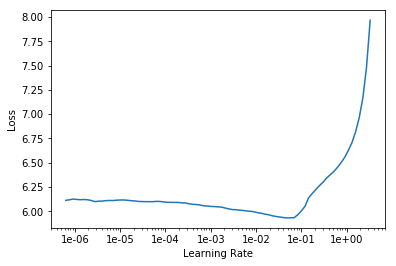

In [0]:
learn.lr_find();
learn.recorder.plot();

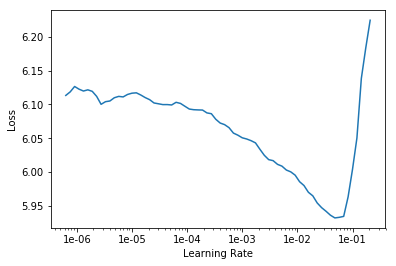

In [0]:
learn.recorder.plot(skip_end=20);

In [0]:
learn.freeze()
learn.fit_one_cycle(2, 1e-2)
learn.save('14train_subword_lm_head');
learn.freeze_to(-2)
learn.fit_one_cycle(2, 1e-2)
learn.save('14train_subword_lm_body_1');
learn.freeze_to(-3)
learn.fit_one_cycle(2, 1e-2)
learn.save('14train_subword_lm_body_2');
## ignore the incomplete epochs

epoch,train_loss,valid_loss,accuracy,time
0,5.219893,5.046435,0.209676,07:26
1,4.920216,4.850117,0.227113,07:27


epoch,train_loss,valid_loss,accuracy,time
0,4.904849,4.863462,0.229831,07:39
1,4.681979,4.631474,0.252843,07:40


epoch,train_loss,valid_loss,accuracy,time
0,4.857399,4.783350,0.238041,08:12
1,4.545446,4.521903,0.265937,08:11


epoch,train_loss,valid_loss,accuracy,time
0,4.383151,4.521655,0.265186,08:34


In [18]:
learn.load('14train_subword_lm_body_2');
learn.unfreeze()
learn.fit_one_cycle(10, 1e-3)
learn.save('14train_subword_lm_body_3');

epoch,train_loss,valid_loss,accuracy,time
0,4.305816,4.514386,0.266883,15:53
1,4.254622,4.488628,0.269113,15:48
2,4.234484,4.463194,0.271799,15:54
3,4.174714,4.443360,0.274023,15:55
4,4.179772,4.426936,0.276127,15:54
5,4.081219,4.413892,0.278025,15:53


Buffered data was truncated after reaching the output size limit.

In [21]:
learn.fit_one_cycle(1, 1e-3)
learn.save('14train_subword_lm_body_4');

epoch,train_loss,valid_loss,accuracy,time
0,4.004398,4.404449,0.279966,15:55


In [0]:
learn.save_encoder('14train_subword_lm_enc')

#### 14 Authors Clas

In [0]:
data_clas = TextClasDataBunch.from_csv(subsets , '14train.csv', tokenizer=mycust_tok, vocab=sp_vocab, bs=bs)
data_clas.save('14train_subword_clas.pkl')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


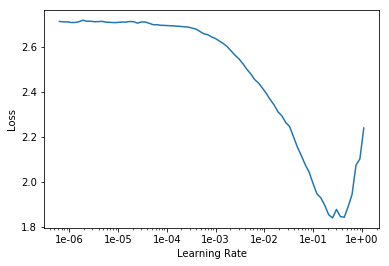

In [24]:
data_clas = load_data(subsets, '14train_subword_clas.pkl',bs=bs)
learn_cls = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5, pretrained=False)
learn_cls.load_encoder('14train_subword_lm_enc')
learn_cls.freeze()
learn_cls.lr_find()
learn_cls.recorder.plot()

In [25]:
learn_cls.fit_one_cycle(2, 1e-2, moms=(0.8,0.7))
learn_cls.save('14train_subword_cls_1')
# learn_cls.load('14train_subword_cls_1')
learn_cls.freeze_to(-2)
learn_cls.fit_one_cycle(2 , slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))
learn_cls.save('14train_subword_cls_2')
# learn_cls.load('14train_subword_cls_2')
learn_cls.freeze_to(-3)
learn_cls.fit_one_cycle(2, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))
learn_cls.save('14train_subword_cls_3')
# learn_cls.load('14train_subword_cls_3')
learn_cls.unfreeze()
learn_cls.fit_one_cycle(4, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))
learn_cls.save('14train_subword_cls_4')

epoch,train_loss,valid_loss,accuracy,time
0,0.452894,0.057153,0.987631,05:00
1,0.128311,0.039862,0.989534,05:05


epoch,train_loss,valid_loss,accuracy,time
0,0.167933,0.042766,0.990485,05:49
1,0.065023,0.035047,0.994291,05:54


epoch,train_loss,valid_loss,accuracy,time
0,0.038542,0.041153,0.993340,08:46
1,0.039725,0.032481,0.991437,08:35


epoch,train_loss,valid_loss,accuracy,time
0,0.018281,0.029909,0.993340,11:15
1,0.026699,0.029267,0.993340,11:08
2,0.015861,0.027887,0.994291,10:57
3,0.017530,0.028703,0.995243,11:06


------------->  **Testing**  <-----------------

In [28]:
pred,targ = testing(subsets/'14test.csv')

1316
Accuracy: 
0.993920972644377
[('manik_bandhopaddhay', 'shirshendu'), ('tarashonkor', 'shorotchandra'), ('shottojit_roy', 'MZI'), ('shirshendu', 'robindronath'), ('shorotchandra', 'shordindu'), ('robindronath', 'tarashonkor'), ('shomresh', 'toslima_nasrin'), ('shunil_gongopaddhay', 'manik_bandhopaddhay')]


In [29]:
from sklearn.metrics import f1_score
out  = f1_score(targ, pred, average=None) #'macro' , also == weighted cuz dataset is balanced
out

array([0.994709, 1.      , 1.      , 0.989362, 1.      , 0.989362, 0.989362, 0.994652, 0.994709, 0.989362, 0.994652,
       0.994652, 0.989362, 0.994709])

In [30]:
out.mean()

0.9939209081440443